In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

%config InlineBackend.figure_format='retina'

sns.set_context('notebook')

### 1. Generate data

In [2]:
def data_generator(y, mu, std=[0.5, 0.5], n=25):
    points = np.random.normal(mu, std, size=(n, 2))
    df = pd.DataFrame(points, columns=['x1', 'x2'])
    df = df.assign(y=y)
    return df


data_dict = {
    '1': {
        'mu': [2, 2],
        'std': [1, 1]
    },
    '2': {
        'mu': [-2, 2],
        'std': [1, 1]
    },
    '3': {
        'mu': [-2, -2],
        'std': [1, 1]
    },
    '4': {
        'mu': [2, -2],
        'std': [1, 1]
    },

}


N = 100

class_dfs = []
for class_, conf in data_dict.items():
    df_class = data_generator(class_, conf['mu'], std=conf['std'], n=N)
    class_dfs.append(df_class)


df = pd.concat(class_dfs).reset_index(drop=True)

In [3]:
df

,x1,x2,y
0,1.634436,0.037317,1
1,2.228602,1.464821,1
2,1.275002,3.447961,1
3,3.203318,2.235383,1
4,2.389323,2.421118,1
...,...,...,...
395,2.024256,-1.404672,4
396,2.194564,-0.829625,4
397,1.015679,-1.028159,4
398,2.060854,-2.610121,4


In [4]:
df.x2.dtype

dtype('float64')

In [7]:
marker_map = {'1': '^', '2': 'o', '3': 's', '4': 'd'}

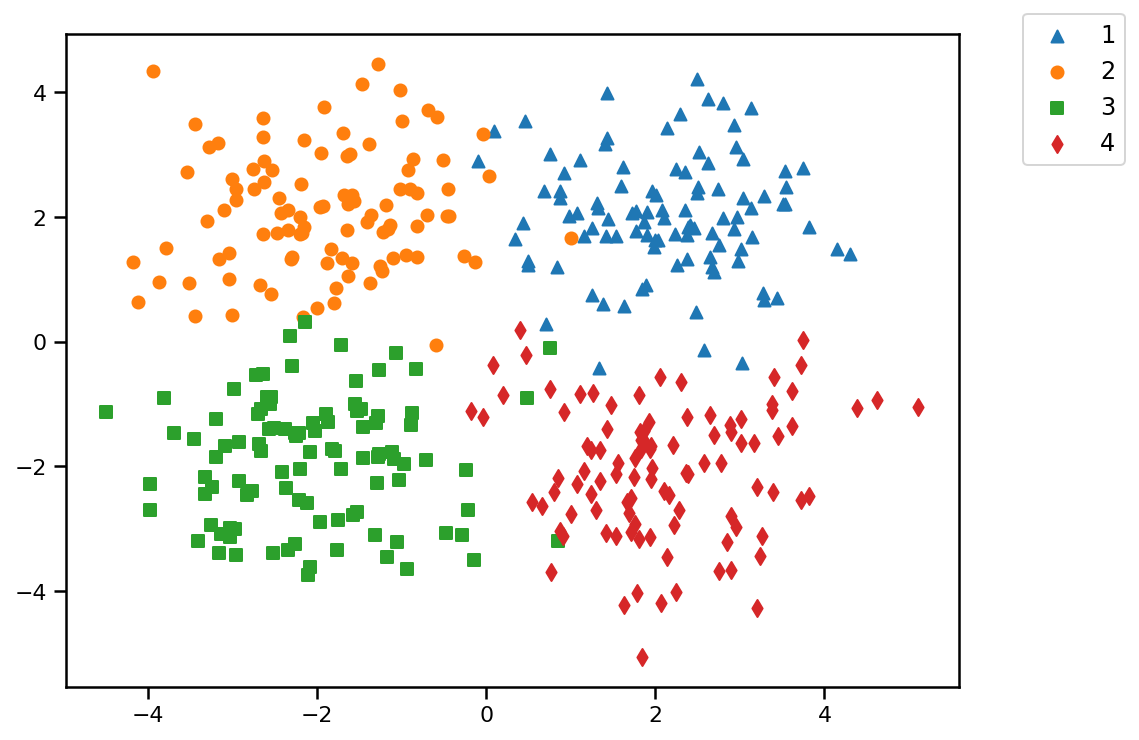

In [10]:
plt.figure(figsize=(8, 6))
for class_ in df.y.unique():
    dftmp = df[df.y == class_]
    plt.scatter(dftmp.x1, dftmp.x2, marker=marker_map[class_], label=class_)
plt.legend(bbox_to_anchor=(1.2, 1.05), fontsize=12);

### 2. Fit Classifier 

In [11]:
model = KNeighborsClassifier(n_neighbors=30)
model.fit(df[['x1', 'x2']], df['y'])
y_hat = model.predict_proba(df[['x1', 'x2']])
y_hat_final = model.predict(df[['x1', 'x2']])

/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [12]:
def plot_pmf(y_hat_arr, title=''):
    plt.figure(figsize=(6,4))
    plt.bar(x=np.array([1, 2, 3, 4], dtype=str), height=y_hat_arr, width=1, edgecolor='black', color='purple', alpha=0.6)
    plt.xlabel('class')
    plt.ylabel('Probability Mass')
    if title == '':
        plt.title('Probability Mass Function')
    else:
        plt.title(title)
    return

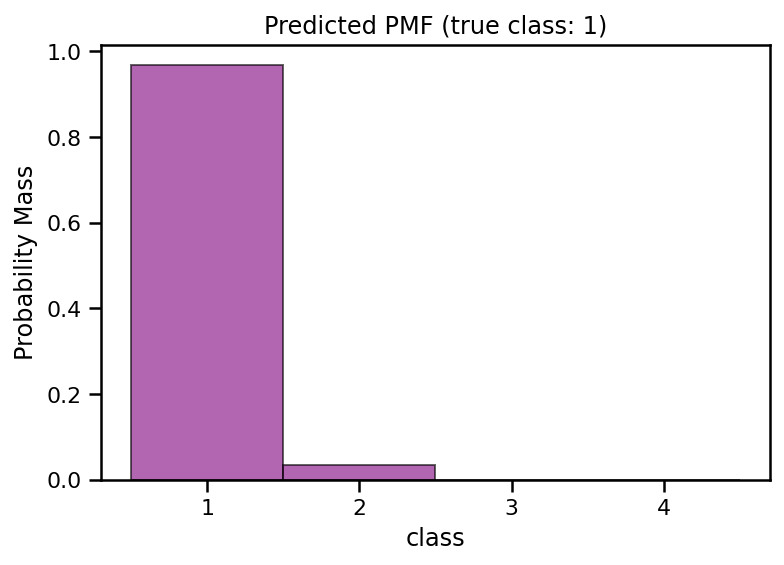

In [13]:
plot_pmf(y_hat[40, :], title=f'Predicted PMF (true class: {df.y.iloc[40]})')

### 3. Conformal Prediction (for labels)

In [14]:
def score(y_soft_max, y_true):
    y_hat_masked = y_soft_max * y_true
    soft_max_prob_true_class = y_hat_masked.sum(axis=1)
    return soft_max_prob_true_class

In [15]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['y']])
y_true = enc.transform(df[['y']]).toarray()

In [127]:
scores = score(y_hat, y_true)

In [135]:
q_hat = np.quantile(scores, 0.1).round(2)
print(f'90% of samples a true class score of at least {q_hat}')

90% of samples a true class score of at least 0.7


Logic: 
* If a new test point, $x_{test}$, has a y_hat with a score for some class about q_hat, it should be included in the the prediction set! 
* If no points meet this criteria, we should not be confident enough to make a prediction!

Which points are we not confident enough in?

In [137]:
df = df.assign(scores=scores)

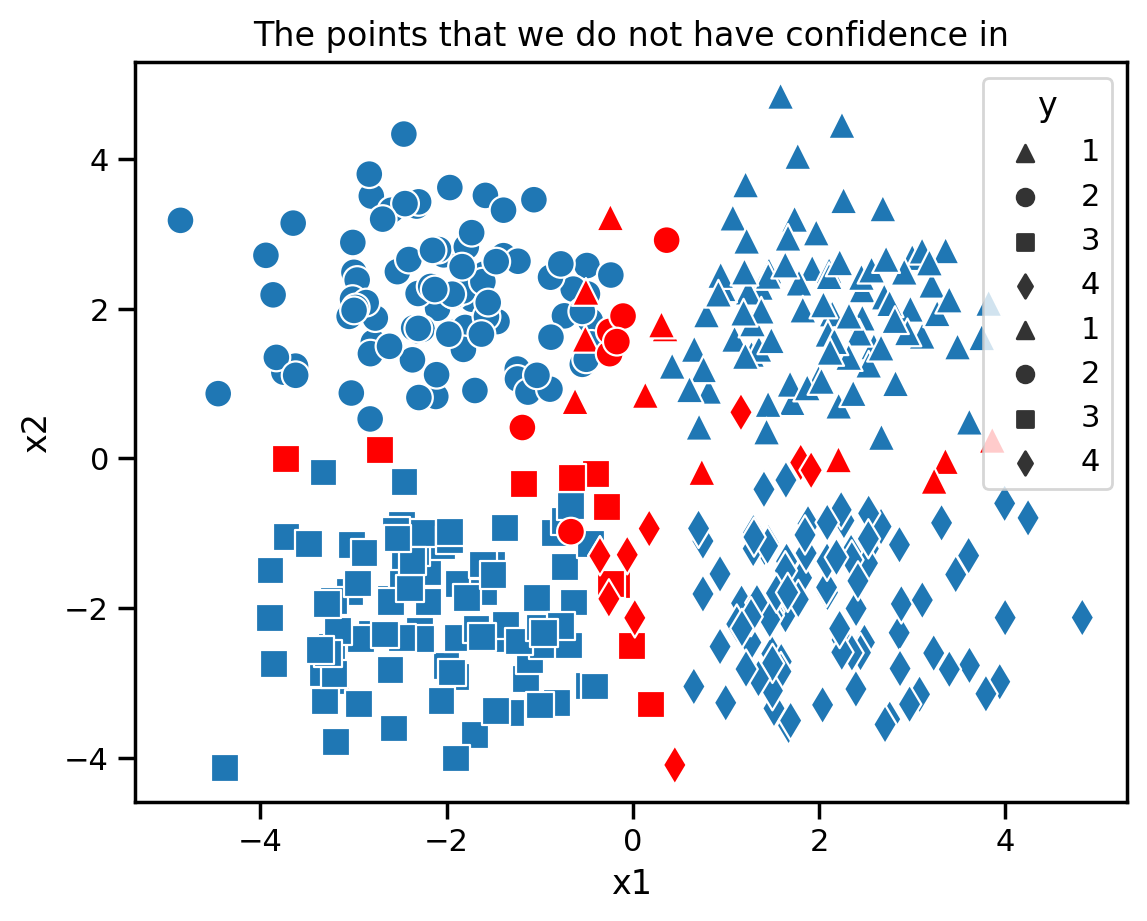

In [146]:
markers_list = ['^', 'o', 's', 'd']
sns.scatterplot(df, x='x1', y='x2', style='y', markers=markers_list, s=100)
sns.scatterplot(df[df.scores < q_hat], x='x1', y='x2', style='y', color='red', markers=markers_list, s=100)
plt.title('The points that we do not have confidence in');

### 4. Conformal Prediction (for each specific class)

In [149]:
def compute_class_conditional_q_hat(g):
    q_hat = np.quantile(g.scores, 0.1)
    return q_hat

q_hats_given_y = df.groupby('y').apply(compute_class_conditional_q_hat)

In [151]:
q_hats_given_y

y
1    0.633333
2    0.733333
3    0.696667
4    0.763333
dtype: float64

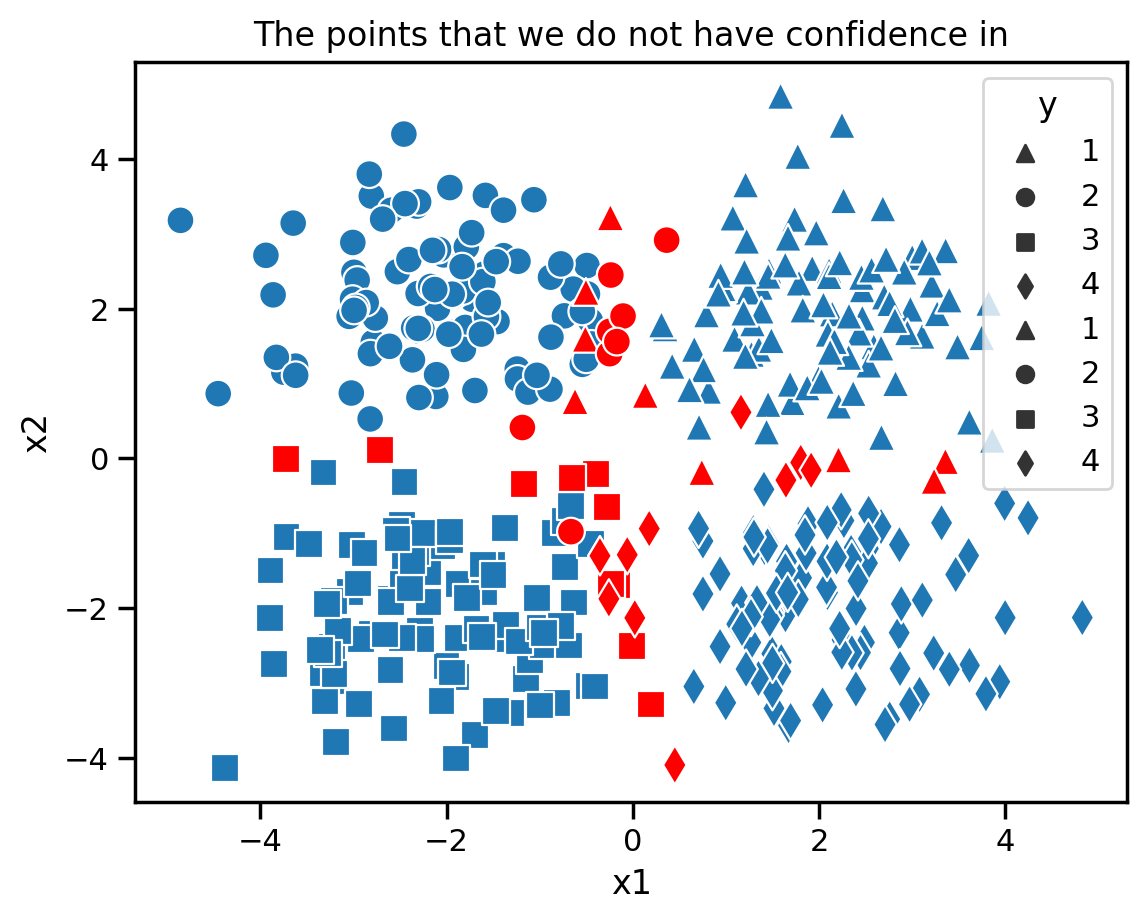

In [155]:
markers_list = ['^', 'o', 's', 'd']
sns.scatterplot(df, x='x1', y='x2', style='y', markers=markers_list, s=100)
for y, q_hat_given_y in q_hats_given_y.items():

    sns.scatterplot(df[(df.y == y) & (df.scores < q_hat_given_y)], x='x1', y='x2', style='y', color='red', markers=markers_list[int(y) - 1], s=100)
plt.title('The points that we do not have confidence in');

### 5. Class Conditional Softmax Confidence Bounds 

In [156]:
def compute_class_conditional_q_hat_bounds(g):
    q_hat_lower = np.quantile(g.scores, 0.1)
    q_hat_upper = np.quantile(g.scores, 0.9)
    return (q_hat_lower, q_hat_upper)

q_hat_confidence_bounds_given_y = df.groupby('y').apply(compute_class_conditional_q_hat_bounds)

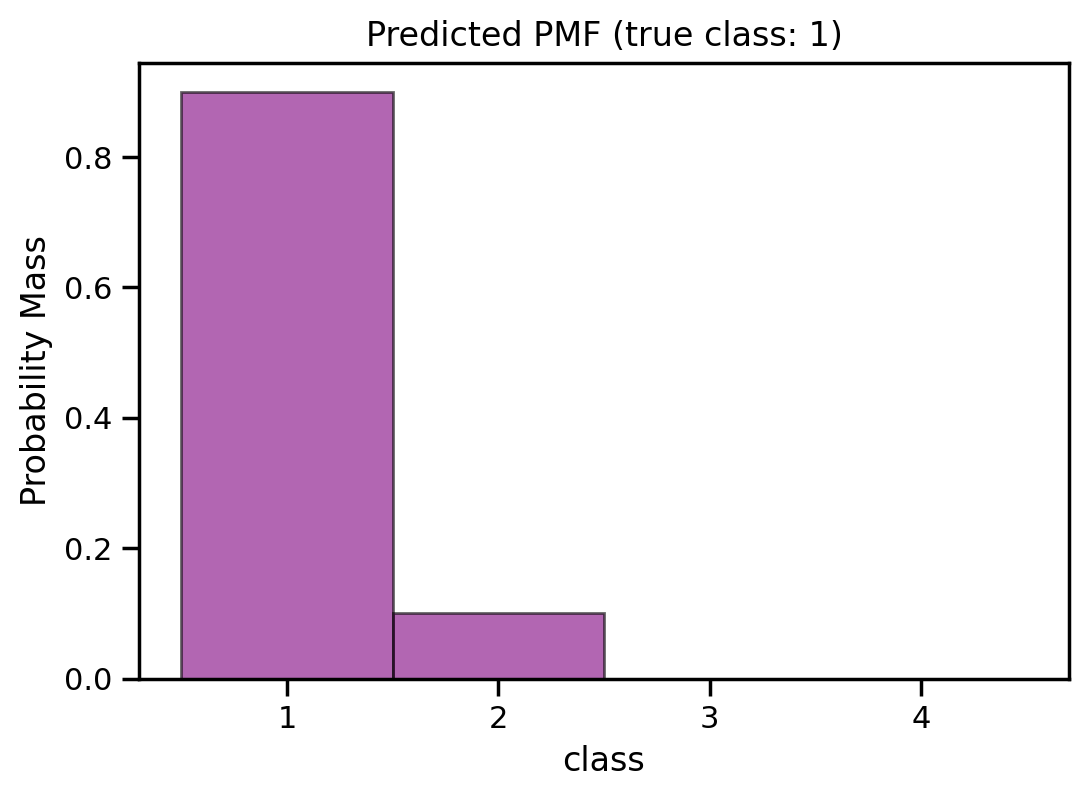

In [158]:
plot_pmf(y_hat[40, :], title=f'Predicted PMF (true class: {df.y.iloc[40]})')

In [213]:
def plot_pmf(y_hat_arr, confidence_bounds=None, title=''):
    plt.figure(figsize=(6,4))
    plt.bar(x=np.array([1, 2, 3, 4], dtype=int), height=y_hat_arr, width=1, edgecolor='black', color='purple', alpha=0.6)
    plt.xlabel('class')
    plt.ylabel('Probability Mass')
    if title == '':
        plt.title('Probability Mass Function')
    else:
        plt.title(title)

    if confidence_bounds is not None:
        for class_, (conf_lower, conf_upper) in confidence_bounds.items():
            class_ = int(class_)
            width = 1
            offset = 0.5
            x_lower = class_ - offset
            x_upper = x_lower + width
            plt.plot([x_lower, x_upper], [conf_lower, conf_lower], zorder=10, color='grey')
            plt.plot([x_lower, x_upper], [conf_upper, conf_upper], zorder=10, color='grey')
    return

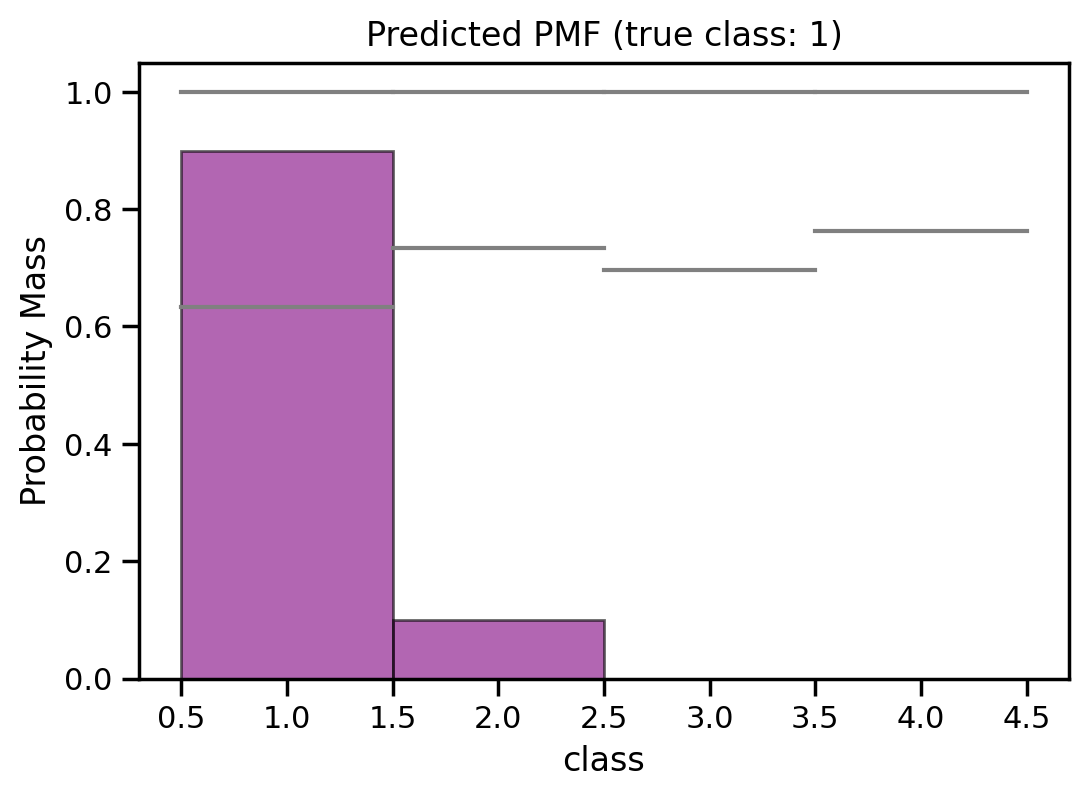

In [214]:
plot_pmf(y_hat[40, :], confidence_bounds=q_hat_confidence_bounds_given_y, title=f'Predicted PMF (true class: {df.y.iloc[40]})')

### 6. Calibration Confidence Bounds

In [139]:
df_cal = pd.DataFrame({'y_hat': y_hat.flatten(), 'y_true': y_true.flatten()})
df_cal = df_cal.assign(y_hat_bin=pd.cut(df_cal.y_hat, bins=10))
df_cal = df_cal.assign(y_hat_bin=df_cal.y_hat_bin.apply(lambda x: x.mid))
df_cal_agg = df_cal.groupby('y_hat_bin').agg({'y_true': 'mean'}).reset_index()

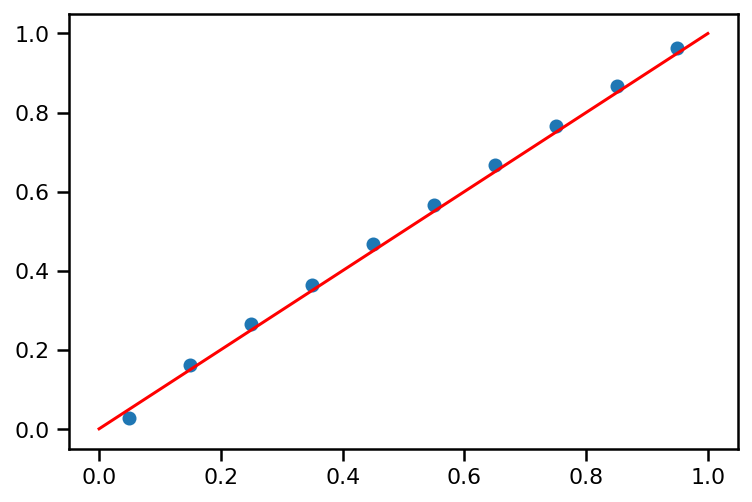

In [140]:
plt.scatter(df_cal_agg.y_hat_bin, df_cal_agg.y_true)
plt.plot([0, 1], [0, 1], color='red');

In [240]:
def compute_prob_conditional_q_hat_bounds(g):
    q_hat_lower = np.quantile(g.y_true, 0.1)
    q_hat_upper = np.quantile(g.y_true, 0.9)
    return (q_hat_lower, q_hat_upper)

df_cal = df_cal.assign(y_hat_bin=pd.cut(df_cal.y_hat, bins=10))
y_hat_bin_confidence_bounds = df_cal.groupby('y_hat_bin').apply(compute_prob_conditional_q_hat_bounds)

### 7. Bin calibration confidence

In [209]:
N = 100_000
class_dfs = []
for class_, conf in data_dict.items():
    df_class = data_generator(class_, conf['mu'], std=conf['std'], n=N)
    class_dfs.append(df_class)
df_train = pd.concat(class_dfs).reset_index(drop=True)

In [210]:
N = 1000

cal_dfs = []
for i in range(0, 100):
    class_dfs = []
    for class_, conf in data_dict.items():
        df_class = data_generator(class_, conf['mu'], std=conf['std'], n=N)
        class_dfs.append(df_class)
    df_cal = pd.concat(class_dfs).reset_index(drop=True)
    cal_dfs.append(df_cal)

In [211]:
model = KNeighborsClassifier(n_neighbors=30)
model.fit(df_train[['x1', 'x2']], df_train['y'])
y_hat = model.predict_proba(df_train[['x1', 'x2']])
y_hat_final = model.predict(df_train[['x1', 'x2']])
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_train[['y']])
y_true = enc.transform(df_train[['y']]).toarray()

/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [195]:
def compute_calibration_quantile_confidence(df):

    # get predictions for calibration df
    model.fit(df[['x1', 'x2']], df['y'])
    y_hat = model.predict_proba(df[['x1', 'x2']])
    
    # get true values for calibration df
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df[['y']])
    y_true = enc.transform(df[['y']]).toarray()

    # Create cal df
    df_cal = pd.DataFrame({'y_hat': y_hat.flatten(), 'y_true': y_true.flatten()})
    df_cal = df_cal.assign(y_hat_bin=pd.cut(df_cal.y_hat, bins=20))
    df_cal_agg = df_cal.groupby('y_hat_bin').agg({'y_true': 'mean'})

    return df_cal_agg


In [196]:
cal_bin_results = []
for cal_df in cal_dfs:
    cal_bin_results.append(compute_calibration_quantile_confidence(cal_df))

In [197]:
df_cal_full = pd.concat(cal_bin_results, axis=1).T.reset_index(drop=True)

In [227]:
df_cal_full

y_hat_bin,"(-0.001, 0.05]","(0.05, 0.1]","(0.1, 0.15]","(0.15, 0.2]","(0.2, 0.25]","(0.25, 0.3]","(0.3, 0.35]","(0.35, 0.4]","(0.4, 0.45]","(0.45, 0.5]","(0.5, 0.55]","(0.55, 0.6]","(0.6, 0.65]","(0.65, 0.7]","(0.7, 0.75]","(0.75, 0.8]","(0.8, 0.85]","(0.85, 0.9]","(0.9, 0.95]","(0.95, 1.0]"
0,0.001603,0.076190,0.126761,0.150794,0.326087,0.308824,0.108108,0.326923,0.384615,0.428571,0.695652,0.630435,0.703704,0.721311,0.829268,0.750000,0.902778,0.870588,0.946078,0.995362
1,0.001527,0.070588,0.111111,0.127517,0.222222,0.280488,0.363636,0.402985,0.461538,0.472727,0.620690,0.500000,0.650000,0.661972,0.763158,0.825243,0.884211,0.890351,0.946860,0.995831
2,0.001891,0.066116,0.120879,0.160305,0.250000,0.229885,0.256410,0.328571,0.321429,0.481481,0.566667,0.630769,0.823529,0.728395,0.833333,0.781513,0.857143,0.865000,0.958333,0.995211
3,0.001080,0.071038,0.125000,0.131579,0.340000,0.309524,0.315789,0.333333,0.342857,0.453125,0.562500,0.746269,0.589744,0.654762,0.760000,0.735632,0.916667,0.884422,0.940594,0.996508
4,0.001806,0.067669,0.133929,0.177778,0.116279,0.333333,0.291667,0.390625,0.470588,0.515152,0.370370,0.611111,0.696970,0.649123,0.673469,0.812500,0.848101,0.894737,0.955665,0.994233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001435,0.065217,0.161905,0.194805,0.217391,0.225000,0.312500,0.250000,0.515152,0.485714,0.550000,0.578947,0.800000,0.733333,0.764706,0.798246,0.816092,0.859729,0.964103,0.995563
96,0.001353,0.071979,0.144144,0.159292,0.187500,0.182927,0.366667,0.378378,0.482759,0.492537,0.629630,0.530303,0.714286,0.704225,0.880952,0.814433,0.818182,0.895652,0.937500,0.995864
97,0.001259,0.067093,0.138211,0.179856,0.183673,0.289157,0.285714,0.383562,0.366667,0.517857,0.484848,0.622951,0.707317,0.709302,0.710526,0.816000,0.803571,0.885246,0.952381,0.996166
98,0.001358,0.078283,0.110092,0.172932,0.153846,0.319588,0.294118,0.397260,0.464286,0.350000,0.710526,0.632353,0.545455,0.642857,0.773585,0.807339,0.847458,0.901235,0.938095,0.995796


In [198]:
df_cal_full.quantile([0.05, 0.95])

y_hat_bin,"(-0.001, 0.05]","(0.05, 0.1]","(0.1, 0.15]","(0.15, 0.2]","(0.2, 0.25]","(0.25, 0.3]","(0.3, 0.35]","(0.35, 0.4]","(0.4, 0.45]","(0.45, 0.5]","(0.5, 0.55]","(0.55, 0.6]","(0.6, 0.65]","(0.65, 0.7]","(0.7, 0.75]","(0.75, 0.8]","(0.8, 0.85]","(0.85, 0.9]","(0.9, 0.95]","(0.95, 1.0]"
0.05,0.000905,0.053646,0.077662,0.111018,0.131383,0.209848,0.172910,0.273877,0.293885,0.407250,0.386260,0.505337,0.525532,0.584223,0.666667,0.736782,0.796262,0.865110,0.920178,0.994501
0.95,0.001878,0.085183,0.166667,0.210267,0.298095,0.334314,0.461486,0.478291,0.520087,0.558461,0.696353,0.700185,0.783478,0.776389,0.863698,0.855778,0.914677,0.920464,0.964183,0.997484


In [282]:
df_cal_full.quantile([0.05, 0.95])

y_hat_bin,"(-0.001, 0.05]","(0.05, 0.1]","(0.1, 0.15]","(0.15, 0.2]","(0.2, 0.25]","(0.25, 0.3]","(0.3, 0.35]","(0.35, 0.4]","(0.4, 0.45]","(0.45, 0.5]","(0.5, 0.55]","(0.55, 0.6]","(0.6, 0.65]","(0.65, 0.7]","(0.7, 0.75]","(0.75, 0.8]","(0.8, 0.85]","(0.85, 0.9]","(0.9, 0.95]","(0.95, 1.0]"
0.05,0.000822,0.054426,0.074858,0.115335,0.140456,0.202568,0.185281,0.285714,0.319385,0.418027,0.393885,0.492800,0.538368,0.607831,0.651163,0.747544,0.793961,0.868510,0.919485,0.994253
0.95,0.001901,0.087250,0.173097,0.205550,0.294324,0.342130,0.448719,0.471225,0.608906,0.545455,0.679491,0.681894,0.769341,0.790889,0.838879,0.858591,0.914912,0.923449,0.965003,0.997694


In [201]:
# 

In [199]:

plt.figure(figsize=(8, 5))
plt.scatter(df_cal_agg.y_hat_bin, df_cal_agg.y_true)
plt.plot([0, 1], [0, 1], color='red');

AttributeError: 'DataFrame' object has no attribute 'y_hat_bin'

<Figure size 576x360 with 0 Axes>

### 8. Can we calibrate our model via temperature scaling ahead of time?

In [212]:
y_hat

array([[1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.23333333, 0.76666667, 0.        , 0.        ],
       ...,
       [0.06666667, 0.        , 0.        , 0.93333333],
       [0.        , 0.        , 0.        , 1.        ],
       [0.03333333, 0.        , 0.        , 0.96666667]])

In [213]:
y_true

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [72]:
from sklearn.metrics import log_loss
from scipy.special import softmax

In [46]:
log_loss(y_true, y_hat)

0.6674731668271571

In [36]:
y_hat[0, :]

array([0.7, 0.2, 0. , 0.1])

In [37]:
softmax(y_hat[0, :])

array([0.3770842 , 0.22871313, 0.18725447, 0.2069482 ])

In [75]:
def softmax(x, T=1):
    """Compute softmax values for each sets of scores in x."""
    z = x / T
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1 ,1 )

In [81]:
T = 0.1

In [82]:
softmax(y_hat, T=T)

array([[9.89972978e-01, 6.67038546e-03, 9.02738505e-04, 2.45389767e-03],
       [2.51599653e-01, 4.90049209e-01, 1.29175569e-01, 1.29175569e-01],
       [9.10527361e-04, 2.40012407e-04, 3.34964297e-04, 9.98514496e-01],
       ...,
       [2.39948757e-04, 2.39948757e-04, 1.27040631e-03, 9.98249696e-01],
       [2.46156884e-02, 3.33137116e-03, 9.05560567e-03, 9.62997335e-01],
       [2.42708945e-03, 9.20757132e-03, 9.79157768e-01, 9.20757132e-03]])

In [122]:
log_loss(y_true, softmax(y_hat, T=0.2435))

0.736923469614562

### 9. Calibration Confidence Bounds

In [63]:
from sklearn.ensemble import RandomForestClassifier

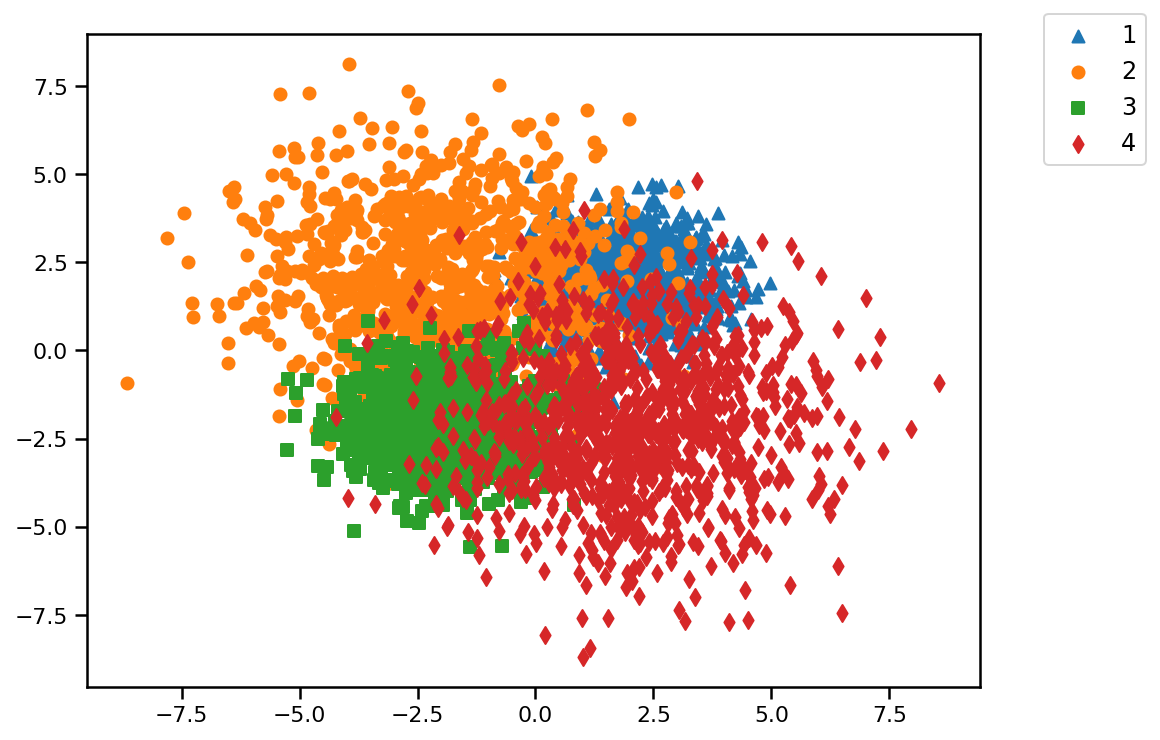

In [92]:
N = 1_000

data_dict = {
    '1': {
        'mu': [2, 2],
        'std': [1, 1]
    },
    '2': {
        'mu': [-2, 2],
        'std': [2, 2]
    },
    '3': {
        'mu': [-2, -2],
        'std': [1, 1]
    },
    '4': {
        'mu': [2, -2],
        'std': [2, 2]
    },

}

class_dfs = []
for class_, conf in data_dict.items():
    df_class = data_generator(class_, conf['mu'], std=conf['std'], n=N)
    class_dfs.append(df_class)


df = pd.concat(class_dfs).reset_index(drop=True)

# model = KNeighborsClassifier(n_neighbors=20)
model = RandomForestClassifier()
model.fit(df[['x1', 'x2']], df['y'])
y_hat = model.predict_proba(df[['x1', 'x2']])

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['y']])
y_true = enc.transform(df[['y']]).toarray()


plt.figure(figsize=(8, 6))
for class_ in df.y.unique():
    dftmp = df[df.y == class_]
    plt.scatter(dftmp.x1, dftmp.x2, marker=marker_map[class_], label=class_)
plt.legend(bbox_to_anchor=(1.2, 1.05), fontsize=12);

In [93]:
df_cal = pd.DataFrame({'y_hat': y_hat.flatten(), 'y_true': y_true.flatten()})
df_cal = df_cal.assign(y_hat_bin=pd.cut(df_cal.y_hat, bins=10))
df_cal = df_cal.assign(y_hat_bin=df_cal.y_hat_bin.apply(lambda x: x.mid))
df_cal_agg = df_cal.groupby('y_hat_bin').agg({'y_true': 'mean'}).reset_index()

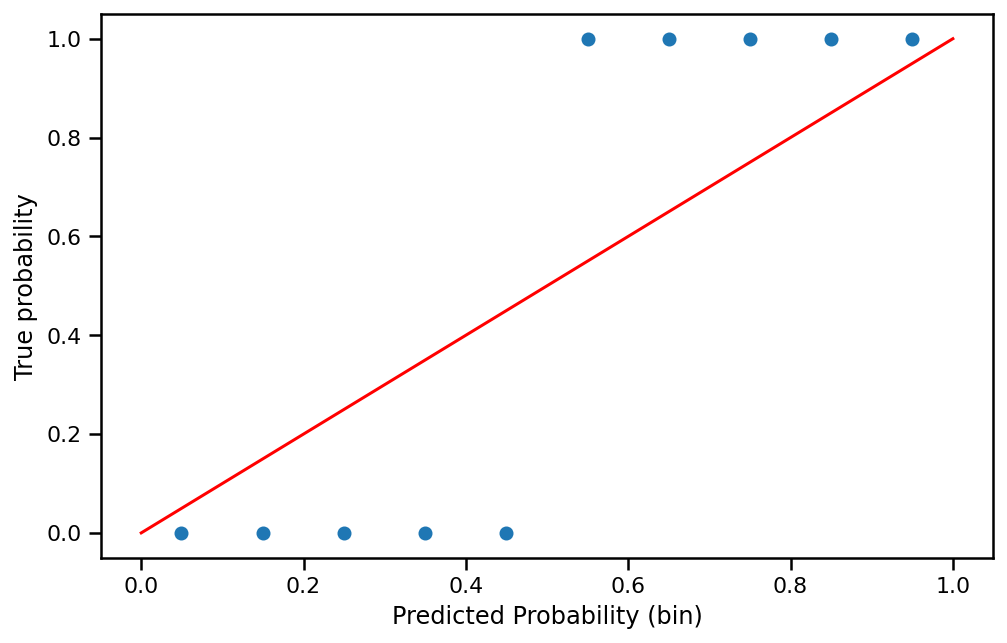

In [94]:
plt.figure(figsize=(8, 5))
plt.scatter(df_cal_agg.y_hat_bin, df_cal_agg.y_true)
plt.xlabel('Predicted Probability (bin)')
plt.ylabel('True probability')
plt.plot([0, 1], [0, 1], color='red');

In [68]:
from sklearn.isotonic import IsotonicRegression as IR

ir = IR(out_of_bounds='clip')
ir.fit(df_cal.y_true, df_cal.y_hat)
y_hat_calibrated = ir.transform(df_cal.y_hat)

df_cal = df_cal.assign(y_hat_calibrated=y_hat_calibrated)

In [69]:
df_cal = df_cal.assign(y_hat_calibrated_bin=pd.cut(df_cal.y_hat_calibrated, bins=10))
df_cal = df_cal.assign(y_hat_calibrated_bin=df_cal.y_hat_calibrated_bin.apply(lambda x: x.mid))
df_cal_agg = df_cal.groupby('y_hat_calibrated_bin').agg({'y_true': 'mean'}).reset_index()

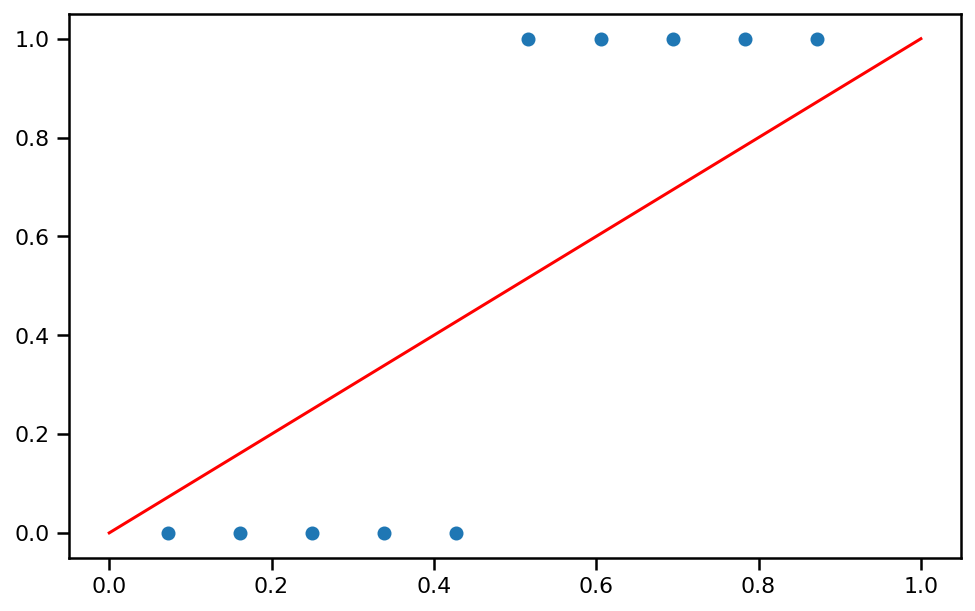

In [70]:
plt.figure(figsize=(8, 5))
plt.scatter(df_cal_agg.y_hat_calibrated_bin, df_cal_agg.y_true)
plt.plot([0, 1], [0, 1], color='red');

In [71]:
# !pip install ml_insights

In [72]:
import ml_insights as mli

In [73]:
df_cal = df_cal.assign(y_hat_calibrated=y_hat_calibrated.flatten())
df_cal = df_cal.assign(y_hat_calibrated_bin=pd.cut(df_cal.y_hat_calibrated, bins=10))
df_cal = df_cal.assign(y_hat_calibrated_bin=df_cal.y_hat_calibrated_bin.apply(lambda x: x.mid))
df_cal_agg = df_cal.groupby('y_hat_calibrated_bin').agg({'y_true': 'mean'}).reset_index()

In [74]:
cal_model = mli.SplineCalib()

In [75]:
cal_model.fit(y_hat, (df.y.astype(int) - 1).values)   
y_hat_calibrated = cal_model.calibrate(y_hat)

In [76]:
df_cal = df_cal.assign(y_hat_calibrated=y_hat_calibrated.flatten())
df_cal = df_cal.assign(y_hat_calibrated_bin=pd.cut(df_cal.y_hat_calibrated, bins=10))
df_cal = df_cal.assign(y_hat_calibrated_bin=df_cal.y_hat_calibrated_bin.apply(lambda x: x.mid))
df_cal_agg = df_cal.groupby('y_hat_calibrated_bin').agg({'y_true': 'mean'}).reset_index()

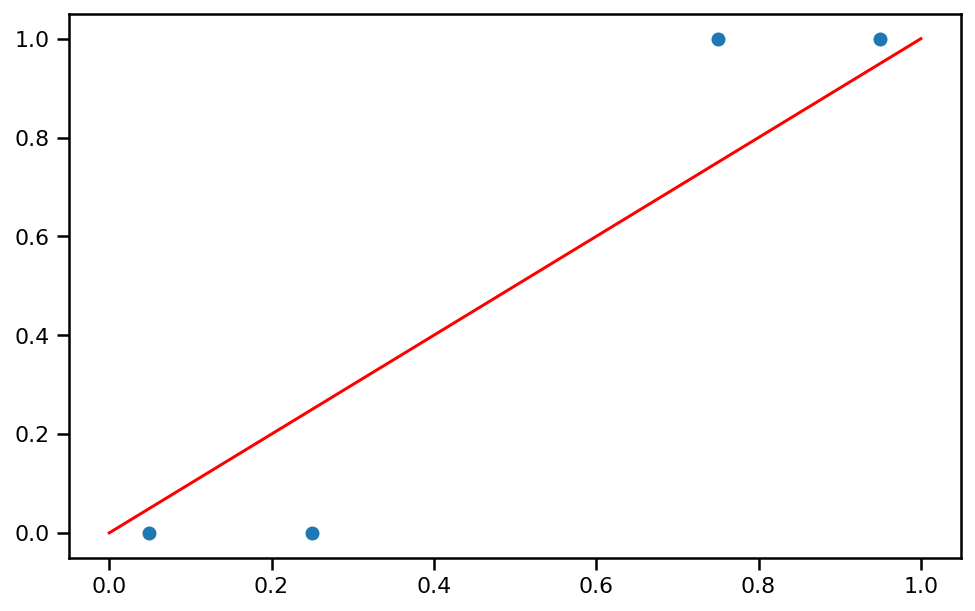

In [77]:
plt.figure(figsize=(8, 5))
plt.scatter(df_cal_agg.y_hat_calibrated_bin, df_cal_agg.y_true)
plt.plot([0, 1], [0, 1], color='red');

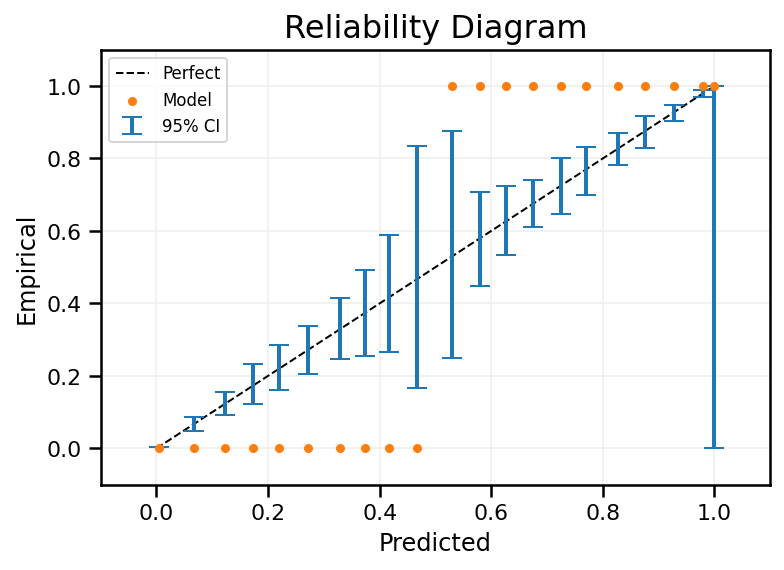

In [85]:
mli.plot_reliability_diagram(df_cal.y_true.values.flatten(), df_cal.y_hat.values.flatten(), marker='.');

In [230]:
# !pip install uncertainty-toolbox

In [80]:
import uncertainty_toolbox as uct

In [81]:
y_true

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [82]:
ir = uct.recalibration.iso_recal(y_hat.flatten(), y_true.flatten())

In [83]:
y_hat_calibrated = ir.predict(y_hat.flatten())

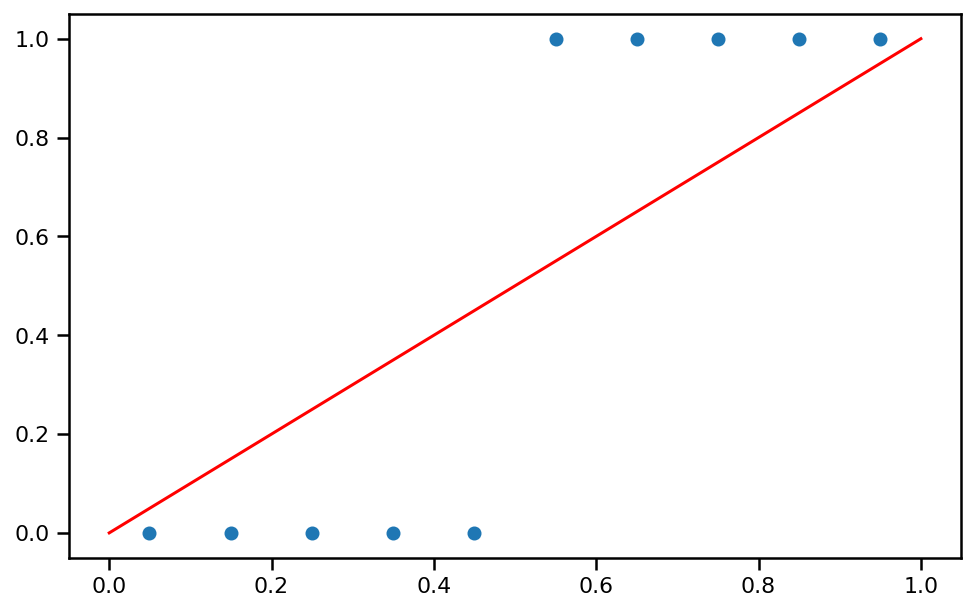

In [84]:
df_cal = df_cal.assign(y_hat_calibrated=y_hat_calibrated.flatten())
df_cal = df_cal.assign(y_hat_calibrated_bin=pd.cut(df_cal.y_hat_calibrated, bins=10))
df_cal = df_cal.assign(y_hat_calibrated_bin=df_cal.y_hat_calibrated_bin.apply(lambda x: x.mid))
df_cal_agg = df_cal.groupby('y_hat_calibrated_bin').agg({'y_true': 'mean'}).reset_index()

plt.figure(figsize=(8, 5))
plt.scatter(df_cal_agg.y_hat_calibrated_bin, df_cal_agg.y_true)
plt.plot([0, 1], [0, 1], color='red');

In [86]:
y_hat

array([[1.  , 0.  , 0.  , 0.  ],
       [0.62, 0.  , 0.  , 0.38],
       [0.81, 0.18, 0.  , 0.01],
       ...,
       [0.4 , 0.  , 0.  , 0.6 ],
       [0.32, 0.  , 0.  , 0.68],
       [0.  , 0.  , 0.  , 1.  ]])

In [87]:
y_hat_calibrated

array([1., 0., 0., ..., 0., 0., 1.])

In [90]:
from sklearn.metrics import log_loss

In [95]:
log_loss(y_true, y_hat)

0.09855890324470024

In [105]:
cv_train_preds = mli.cv_predictions(model, df[['x1', 'x2']], df.y.astype(int).values)

ValueError: shape mismatch: value array of shape (800,4) could not be broadcast to indexing result of shape (800,5)

In [104]:
df.y.value_counts()

1    1000
2    1000
3    1000
4    1000
Name: y, dtype: int64

In [100]:
df[['x1', 'x2']]

,x1,x2
0,1.398031,2.760251
1,3.106329,2.771638
2,1.276661,4.433848
3,0.229757,0.967371
4,2.169729,2.089394
...,...,...
3995,2.092484,-5.380392
3996,2.151254,-1.058802
3997,2.610497,-0.422232
3998,4.330705,-2.162695
